In [1]:
! nvidia-smi


Fri Jun 11 19:02:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)
sys.path.append("/content/gdrive/MyDrive")

%reload_ext tensorboard

Mounted at /content/gdrive


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

# custom torch package
import torchkit
from torchkit.run import train, test, fit
from torchkit.data.dataloader import MNIST_Loader
from torchkit.models.mnist_net import  NoFCNet2
from torchkit.utils import data_utils, model_utils

In [4]:

BATCH_SIZE=128
train_loader, test_loader = MNIST_Loader(BATCH_SIZE)

In [5]:
class GlobalConfig:
    seed = 1992
    num_classes = 10
    batch_size = 128
    EPOCHS = 20
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data
    input_image_size = (1, 28, 28)
    trainloader = train_loader
    testloader = test_loader

    # model data normalization
    channel_norm = 'GroupNorm'
    channel_norm_params = {'GroupNorm': {'num_groups':2},
                 'BatchNorm2d':{'affine':True},
                 'LayerNorm': {'normalized_shape':10}}
                

    # regularizer
    dropout_value = 0.05

    # loss
    loss_function = 'CrossEntropyLoss'

    # scheduler
    lr_scheduler = 'OneCycleLR'
    lr_scheduler_params = {'StepLR': {'step_size':6, 'gamma':0.1},
                
                'ReduceLROnPlateau': {'mode':'min', 'factor':0.5, 'patience':2, 'threshold':0.0001,
                                      'threshold_mode':'rel', 'cooldown':0, 'min_lr':1e-4,
                                      'eps':1e-08, 'verbose':True},
                'OneCycleLR': {'max_lr': 0.2, 'steps_per_epoch':len(trainloader), 'div_factor':20, 'epochs':EPOCHS }}
                                

    # optimizer
    optimizer = 'SGD'
    optimizer_params = {'SGD':{'lr':0.01, 'momentum':0.9}}

    # store model stats
    model_results = {'TestAccuracy': [], 
                  'TrainAccuracy': [],
                  'TestLoss': [],
                  'TrainLoss':[]}

    # Params
    misclassified=True
    L1Lambda=False

    
modelconfig = GlobalConfig


In [6]:
# NoFCNet2 - BatchNorm2d
modelconfig.channel_norm = 'BatchNorm2d'
modelconfig.L1Lambda = True

model = NoFCNet2(modelconfig).to(modelconfig.device)
summary(model, input_size=modelconfig.input_image_size)
train_misc_img, test_misc_img, bn_model_results = fit(model=model, config=modelconfig)

# store the model results
batchnorm_results = modelconfig.model_results

# Plot misclassified images


  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 26, 26]           1,440
              ReLU-6           [-1, 16, 26, 26]               0
       BatchNorm2d-7           [-1, 16, 26, 26]              32
           Dropout-8           [-1, 16, 26, 26]               0
         MaxPool2d-9           [-1, 16, 13, 13]               0
           Conv2d-10            [-1, 8, 13, 13]             128
           Conv2d-11           [-1, 10, 11, 11]             720
             ReLU-12           [-1, 10, 11, 11]               0
      BatchNorm2d-13           [-1, 10, 11, 11]              20
          Dropout-14           [-1, 10,

Train set: batch_id=468  Average loss: 0.22204561531543732 Accuracy: 85.383: 100%|██████████| 469/469 [00:31<00:00, 14.90it/s]


Validation loss has  decreased from inf to 0.0006. Saving the model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9778/10000 (97.78%)


EPOCH:  2 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.0697312280535698 Accuracy: 97.628: 100%|██████████| 469/469 [00:31<00:00, 14.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0006 to 0.0004. Saving the model

Test set: Average loss: 0.0004, Accuracy: 9845/10000 (98.45%)


EPOCH:  3 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.027044204995036125 Accuracy: 98.052: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0004 to 0.0003. Saving the model

Test set: Average loss: 0.0003, Accuracy: 9890/10000 (98.90%)


EPOCH:  4 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.014521967619657516 Accuracy: 98.315: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0003 to 0.0003. Saving the model

Test set: Average loss: 0.0003, Accuracy: 9895/10000 (98.95%)


EPOCH:  5 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.09686979651451111 Accuracy: 98.513: 100%|██████████| 469/469 [00:32<00:00, 14.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0003 to 0.0003. Saving the model

Test set: Average loss: 0.0003, Accuracy: 9905/10000 (99.05%)


EPOCH:  6 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.027382122352719307 Accuracy: 98.67: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0003 to 0.0002. Saving the model

Test set: Average loss: 0.0002, Accuracy: 9910/10000 (99.10%)


EPOCH:  7 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.01813211850821972 Accuracy: 98.638: 100%|██████████| 469/469 [00:30<00:00, 15.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9902/10000 (99.02%)


EPOCH:  8 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.11110687255859375 Accuracy: 98.773: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0002 to 0.0002. Saving the model

Test set: Average loss: 0.0002, Accuracy: 9910/10000 (99.10%)


EPOCH:  9 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.03597303479909897 Accuracy: 98.757: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0002 to 0.0002. Saving the model

Test set: Average loss: 0.0002, Accuracy: 9935/10000 (99.35%)


EPOCH:  10 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.09298509359359741 Accuracy: 98.88: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9911/10000 (99.11%)


EPOCH:  11 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.041566431522369385 Accuracy: 98.837: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9913/10000 (99.13%)


EPOCH:  12 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.05427548661828041 Accuracy: 98.833: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0002 to 0.0002. Saving the model

Test set: Average loss: 0.0002, Accuracy: 9925/10000 (99.25%)


EPOCH:  13 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.03276316449046135 Accuracy: 99.0: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9921/10000 (99.21%)


EPOCH:  14 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.002280924003571272 Accuracy: 99.0: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9921/10000 (99.21%)


EPOCH:  15 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.01321102399379015 Accuracy: 98.998: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9920/10000 (99.20%)


EPOCH:  16 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.02872990258038044 Accuracy: 99.033: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9925/10000 (99.25%)


EPOCH:  17 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.05253468453884125 Accuracy: 99.025: 100%|██████████| 469/469 [00:31<00:00, 15.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0002 to 0.0002. Saving the model

Test set: Average loss: 0.0002, Accuracy: 9937/10000 (99.37%)


EPOCH:  18 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.1600412279367447 Accuracy: 99.012: 100%|██████████| 469/469 [00:30<00:00, 15.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9935/10000 (99.35%)


EPOCH:  19 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.008424022234976292 Accuracy: 99.103: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased from 0.0002 to 0.0002. Saving the model

Test set: Average loss: 0.0002, Accuracy: 9938/10000 (99.38%)


EPOCH:  20 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.04714178666472435 Accuracy: 99.07: 100%|██████████| 469/469 [00:31<00:00, 15.06it/s]


Validation loss has  decreased from 0.0002 to 0.0001. Saving the model

Test set: Average loss: 0.0001, Accuracy: 9939/10000 (99.39%)



IndexError: ignored

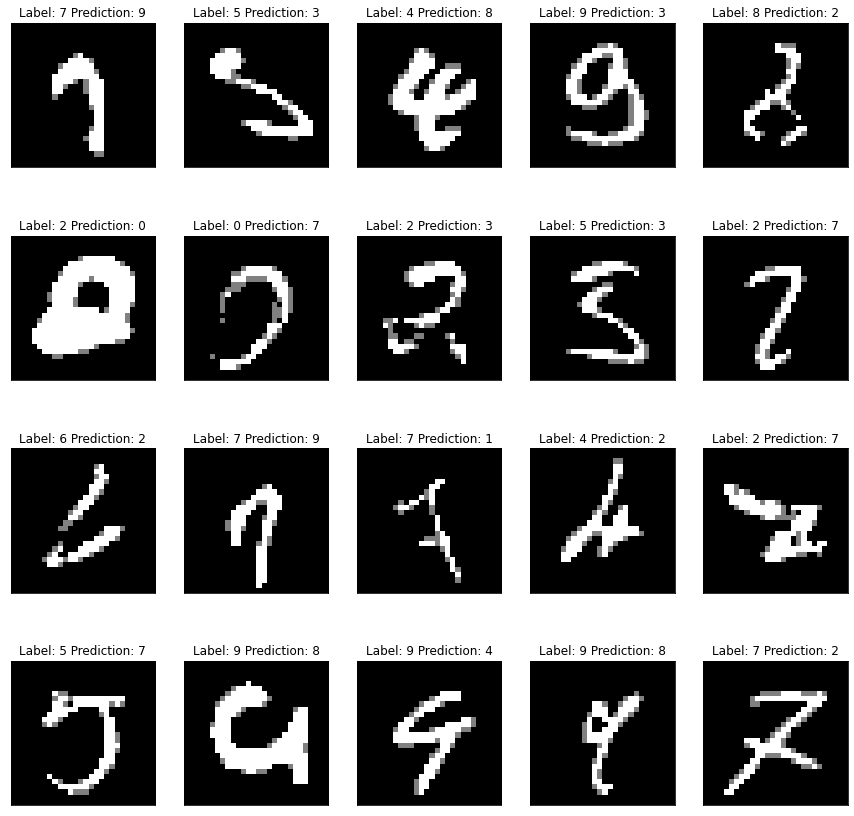

In [9]:

test_misc_images = [test_misc_img[i] for i in range(20)]
data_utils.plot_images(test_misc_images, 'test_misc_batchnorm.png')

In [ ]:
%tensorboard --logdir /content/runs

  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
         GroupNorm-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 26, 26]           1,440
              ReLU-6           [-1, 16, 26, 26]               0
         GroupNorm-7           [-1, 16, 26, 26]              32
           Dropout-8           [-1, 16, 26, 26]               0
         MaxPool2d-9           [-1, 16, 13, 13]               0
           Conv2d-10            [-1, 8, 13, 13]             128
           Conv2d-11           [-1, 10, 11, 11]             720
             ReLU-12           [-1, 10, 11, 11]               0
        GroupNorm-13           [-1, 10, 11, 11]              20
          Dropout-14           [-1, 10,

Train set: batch_id=468  Average loss: 0.10052701085805893 Accuracy: 85.205: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9795/10000 (97.95%)


EPOCH:  2 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.0589509941637516 Accuracy: 97.567: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9825/10000 (98.25%)


EPOCH:  3 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.08036071807146072 Accuracy: 97.873: 100%|██████████| 469/469 [00:32<00:00, 14.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9873/10000 (98.73%)


EPOCH:  4 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.08254372328519821 Accuracy: 98.208: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9888/10000 (98.88%)


EPOCH:  5 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.0211679358035326 Accuracy: 98.408: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9848/10000 (98.48%)


EPOCH:  6 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.08194776624441147 Accuracy: 98.602: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9890/10000 (98.90%)


EPOCH:  7 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.02604673057794571 Accuracy: 98.705: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9910/10000 (99.10%)


EPOCH:  8 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.06444258987903595 Accuracy: 98.7: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9888/10000 (98.88%)


EPOCH:  9 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.03001604788005352 Accuracy: 98.752: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9907/10000 (99.07%)


EPOCH:  10 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.024795932695269585 Accuracy: 98.77: 100%|██████████| 469/469 [00:30<00:00, 15.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9915/10000 (99.15%)


EPOCH:  11 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.06506583094596863 Accuracy: 98.865: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9924/10000 (99.24%)


EPOCH:  12 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.031288620084524155 Accuracy: 98.917: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9913/10000 (99.13%)


EPOCH:  13 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.041107308119535446 Accuracy: 98.918: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9895/10000 (98.95%)


EPOCH:  14 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.10915469378232956 Accuracy: 98.897: 100%|██████████| 469/469 [00:31<00:00, 15.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9917/10000 (99.17%)


EPOCH:  15 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.005509674083441496 Accuracy: 98.968: 100%|██████████| 469/469 [00:30<00:00, 15.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9930/10000 (99.30%)


EPOCH:  16 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.006190065294504166 Accuracy: 99.045: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9916/10000 (99.16%)


EPOCH:  17 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.031279537826776505 Accuracy: 99.053: 100%|██████████| 469/469 [00:30<00:00, 15.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9931/10000 (99.31%)


EPOCH:  18 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.024994289502501488 Accuracy: 99.152: 100%|██████████| 469/469 [00:31<00:00, 15.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9918/10000 (99.18%)


EPOCH:  19 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.010498639196157455 Accuracy: 99.085: 100%|██████████| 469/469 [00:31<00:00, 15.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9937/10000 (99.37%)


EPOCH:  20 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.03964925929903984 Accuracy: 99.065: 100%|██████████| 469/469 [00:30<00:00, 15.21it/s]



Test set: Average loss: 0.0002, Accuracy: 9930/10000 (99.30%)

22 0


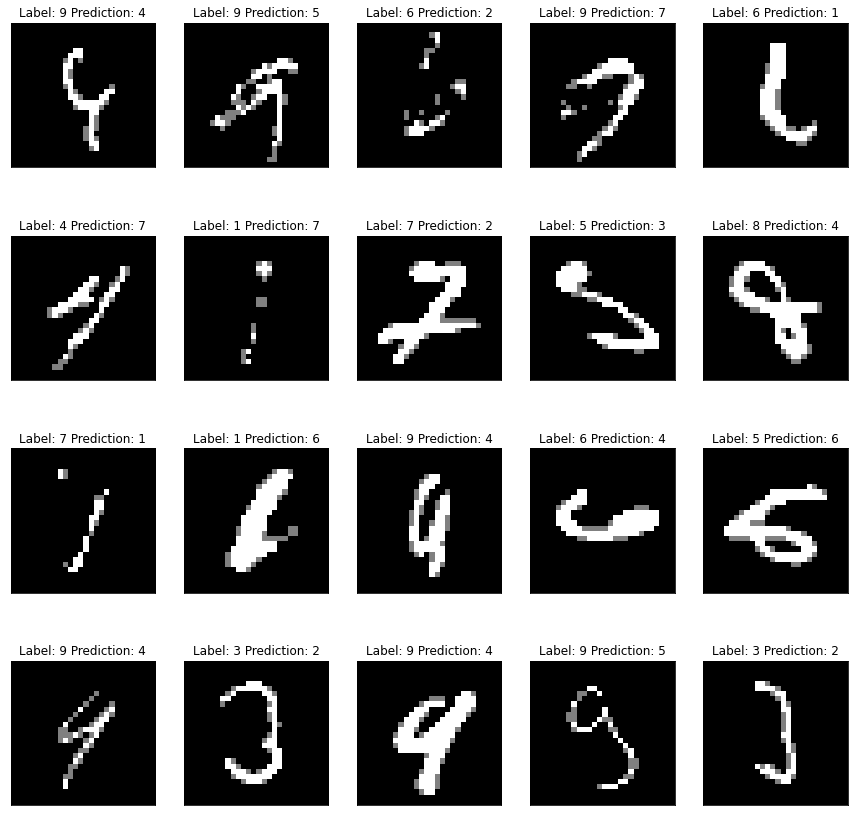

In [13]:
# NoFCNet2 - GroupNorm
modelconfig.channel_norm = 'GroupNorm'
model = NoFCNet2(modelconfig).to(modelconfig.device)
summary(model, input_size=modelconfig.input_image_size)
train_misc_img, test_misc_img, bn_model_results = fit(model=model, config=modelconfig)

# store the model results
groupnorm_results = modelconfig.model_results

# Plot misclassified images
test_misc_images = [test_misc_img[i] for i in range(20)]
print(len(test_misc_img), len(train_misc_img))

data_utils.plot_images(test_misc_images, 'test_misc_groupnorm.png')


In [ ]:
%tensorboard --logdir /content/runs

In [14]:
# NoFCNet2 - LayerNorm
modelconfig.channel_norm = 'LayerNorm'
model = NoFCNet2(modelconfig).to(modelconfig.device)
summary(model, input_size=modelconfig.input_image_size)
train_misc_img, test_misc_img, bn_model_results = fit(model=model, config=modelconfig)

# store the model results
layernorm_results = modelconfig.model_results


  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
         GroupNorm-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 26, 26]           1,440
              ReLU-6           [-1, 16, 26, 26]               0
         GroupNorm-7           [-1, 16, 26, 26]              32
           Dropout-8           [-1, 16, 26, 26]               0
         MaxPool2d-9           [-1, 16, 13, 13]               0
           Conv2d-10            [-1, 8, 13, 13]             128
           Conv2d-11           [-1, 10, 11, 11]             720
             ReLU-12           [-1, 10, 11, 11]               0
        GroupNorm-13           [-1, 10, 11, 11]              20
          Dropout-14           [-1, 10,

Train set: batch_id=468  Average loss: 0.18859946727752686 Accuracy: 85.842: 100%|██████████| 469/469 [00:31<00:00, 15.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9776/10000 (97.76%)


EPOCH:  2 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.1087891235947609 Accuracy: 97.6: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9830/10000 (98.30%)


EPOCH:  3 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.09957330673933029 Accuracy: 98.087: 100%|██████████| 469/469 [00:30<00:00, 15.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9838/10000 (98.38%)


EPOCH:  4 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.07870087027549744 Accuracy: 98.338: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9877/10000 (98.77%)


EPOCH:  5 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.27648022770881653 Accuracy: 98.567: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9914/10000 (99.14%)


EPOCH:  6 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.002438618801534176 Accuracy: 98.668: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9901/10000 (99.01%)


EPOCH:  7 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.10619664937257767 Accuracy: 98.675: 100%|██████████| 469/469 [00:33<00:00, 14.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9908/10000 (99.08%)


EPOCH:  8 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.052728310227394104 Accuracy: 98.772: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9923/10000 (99.23%)


EPOCH:  9 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.04387379810214043 Accuracy: 98.787: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9882/10000 (98.82%)


EPOCH:  10 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.04796304926276207 Accuracy: 98.913: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9913/10000 (99.13%)


EPOCH:  11 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.012597435154020786 Accuracy: 98.905: 100%|██████████| 469/469 [00:31<00:00, 15.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9933/10000 (99.33%)


EPOCH:  12 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.02342708222568035 Accuracy: 98.993: 100%|██████████| 469/469 [00:31<00:00, 15.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9893/10000 (98.93%)


EPOCH:  13 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.006627917755395174 Accuracy: 98.983: 100%|██████████| 469/469 [00:31<00:00, 15.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9868/10000 (98.68%)


EPOCH:  14 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.03721485286951065 Accuracy: 98.997: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9929/10000 (99.29%)


EPOCH:  15 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.04237450659275055 Accuracy: 99.092: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9934/10000 (99.34%)


EPOCH:  16 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.00617707846686244 Accuracy: 99.092: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9917/10000 (99.17%)


EPOCH:  17 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.06343469768762589 Accuracy: 99.09: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9919/10000 (99.19%)


EPOCH:  18 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.041070323437452316 Accuracy: 98.997: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9928/10000 (99.28%)


EPOCH:  19 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.07793143391609192 Accuracy: 99.175: 100%|██████████| 469/469 [00:30<00:00, 15.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9932/10000 (99.32%)


EPOCH:  20 LR:  [0.010000000000000009]


Train set: batch_id=468  Average loss: 0.009048010222613811 Accuracy: 99.168: 100%|██████████| 469/469 [00:30<00:00, 15.21it/s]



Test set: Average loss: 0.0002, Accuracy: 9933/10000 (99.33%)



IndexError: ignored

23 0


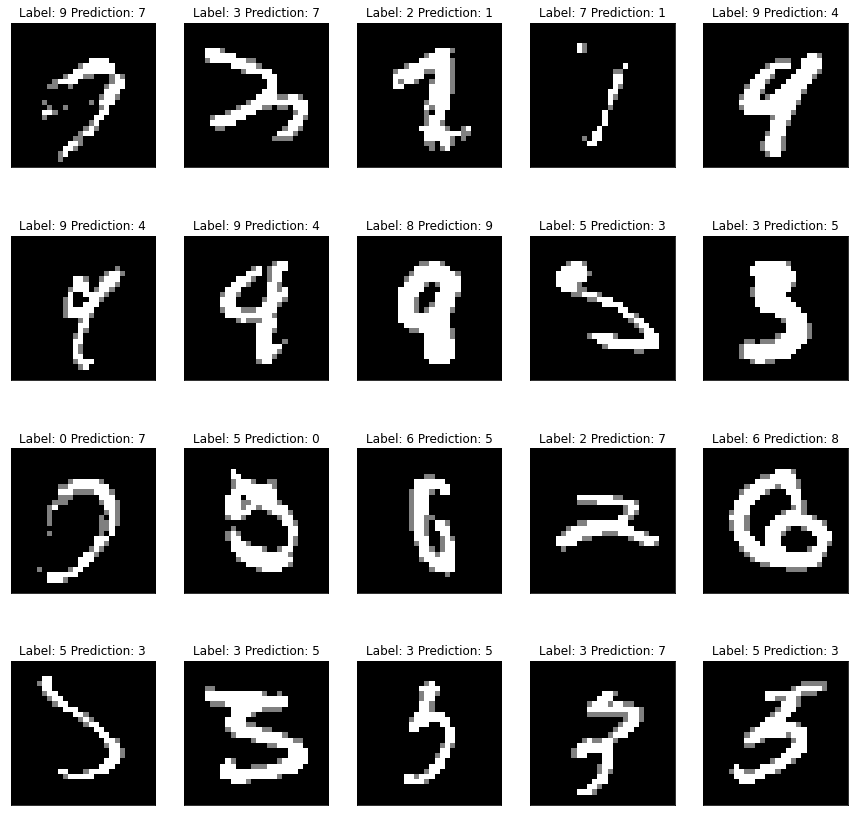

In [16]:

# Plot misclassified images
test_misc_images = [test_misc_img[i] for i in range(20)]
print(len(test_misc_img), len(train_misc_img))

data_utils.plot_images(test_misc_images, 'test_misc_layernorm.png')


In [42]:
_results = batchnorm_results
testacc = batchnorm_results['TestAccuracy']
trainacc = batchnorm_results['TrainAccuracy']
testloss = batchnorm_results['TestLoss']
trainloss = batchnorm_results['TrainLoss']

In [55]:
plot_details_dict = {'Test Accuracy(%)': 'Validation Accuracy across Batch, Group & Layer Normalized Models',
                     'Train Accuracy(%)': 'Train Accuracy across Batch, Group & Layer Normalized Models',
                     'Test Loss(%)': 'Validation Loss across Batch, Group & Layer Normalized Models',
                     'Train Loss(%)': 'Train Loss across Batch, Group & Layer Normalized Models'}


def plot_curve(data, y_label):
  # Plotting both the curves simultaneously
  with plt.style.context('dark_background'):# fivethirtyeight
    plt.plot(data[0:20], color='r', label='BatchNorm')
    plt.plot(data[21:40], color='g', label='GroupNorm')
    plt.plot(data[41:61], color='y', label='LayerNorm')
      
    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(plot_details_dict[y_label])
      
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
  

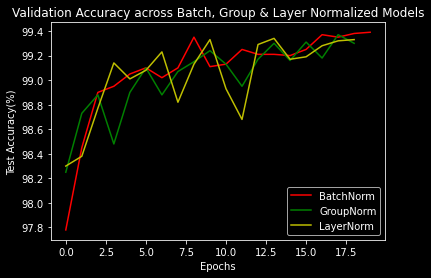

In [56]:
plot_curve(testacc, "Test Accuracy(%)")

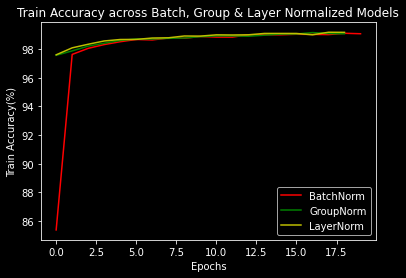

In [57]:
plot_curve(trainacc, "Train Accuracy(%)")

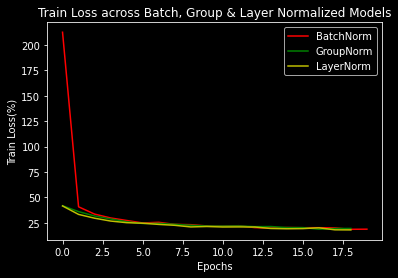

In [58]:
plot_curve(trainloss, "Train Loss(%)")

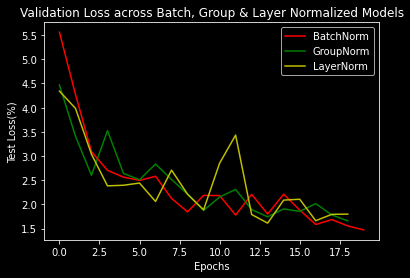

In [59]:
plot_curve(testloss, "Test Loss(%)")